100%|██████████| 50/50 [49:05<00:00, 58.91s/it]


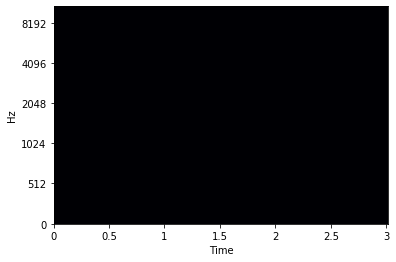

In [13]:
import os
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment
from tqdm import tqdm
from IPython.display import Audio
from scipy.io.wavfile import write
import random

SOURCES = "D:\DSD100/Sources/dev"
MIXTURES = "D:\DSD100/Mixtures/Dev"
segment_length = 3 #seconds

#wav_pairs shape -> [pair[mix[seg_length], vocals[seg_length], pair[mix[], vocals[]]]
wav_pairs = []
for wav_paths in tqdm([[os.path.join(MIXTURES, x, "mixture.wav"), os.path.join(SOURCES, x, "vocals.wav")] for x in next(os.walk(MIXTURES))[1]]):
    duration = int(AudioSegment.from_file(wav_paths[0]).duration_seconds) 
    for i in range(0, duration-segment_length, segment_length):
        wav_pair = [] #[mixture, vocals]
        for wav_path in wav_paths:
            y, sr = librosa.load(wav_path, offset=i, duration=segment_length)
            ps = librosa.feature.melspectrogram(y=y, sr=sr)
            wav_pair.append(ps)
        wav_pairs.append(wav_pair)

    


In [18]:
cl = 24 #context_length
scl = int(cl/2) #side_context_length

#training_data shape -> [pair[mix[128 x cl], vocal[128]], pair[mix[128 x cl], vocal[128]]]
training_data = []
for mix, vocal in tqdm(wav_pairs):
    n_mels, t = mix.shape
    for i in range(scl, t-scl):
        mask = np.array([0.0 if x < 10 else 1.0 for x in vocal[:, i]])
#         vocals_exist = max(mask) == 1.0
#         training_data.append((mix[:, i-scl:i+scl+1], 1 if vocals_exist else 0))
        training_data.append((mix[:, i-scl:i+scl+1], mask))
    

# librosa.display.specshow(training_data[0][1], y_axis="mel", x_axis="time")
# inv_ps = librosa.feature.inverse.mel_to_audio(training_data[0][0])
# display(Audio(inv_ps, rate=sr))

100%|██████████| 4300/4300 [05:53<00:00, 12.15it/s]


In [20]:
random.shuffle(training_data)

X_train = []
Y_train = []
for mix, vocals in tqdm(training_data):
    X_train.append(mix)
    Y_train.append(vocals)
X_train = np.expand_dims(np.array(X_train), axis = 3) #shape -> (x, 128, 25, 1)
Y_train = np.array(Y_train) #shape -> (x, 128)


100%|██████████| 455800/455800 [00:01<00:00, 384077.80it/s]


In [37]:
import pickle

# pickle_out = open("D:\X.pickle", "wb")
# pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()



In [34]:
# pickle_in = open("D:\X.pickle", "rb")
# testing = pickle.load(pickle_in)
# testing.shape

pickle_in.close()

In [38]:
X_train.shape


(455800, 128, 25, 1)

In [42]:
import h5py
h5f = h5py.File("D:\\train_data.h5", 'w')
h5f.create_dataset('X_train', data=X_train)
h5f.close()

OSError: Can't write data (file write failed: time = Thu May 14 03:47:27 2020
, filename = 'D:\train_data.h5', file descriptor = 6, errno = 28, error message = 'No space left on device', buf = 000002AE7BDEF03F, total write size = 3686756353, bytes this sub-write = 2147483647, bytes actually written = 18446744073709551615, offset = 2147485695)

In [43]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU
model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', input_shape=(128, 25, 1)))
model.add(LeakyReLU())
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.MSE, optimizer=sgd, metrics=['accuracy'])

In [45]:
model.fit(X_train, Y_train, batch_size=32, validation_split=0.2, epochs=50)

Train on 364640 samples, validate on 91160 samples
Epoch 1/50
364640/364640 [==============================] - 2527s 7ms/step - loss: 0.0123 - accuracy: 0.0123 - val_loss: 0.0107 - val_accuracy: 0.0271
Epoch 2/50
364640/364640 [==============================] - 1971s 5ms/step - loss: 0.0108 - accuracy: 0.0251 - val_loss: 0.0106 - val_accuracy: 0.0300
Epoch 3/50
364640/364640 [==============================] - 22641s 62ms/step - loss: 0.0107 - accuracy: 0.0263 - val_loss: 0.0105 - val_accuracy: 0.0301
Epoch 4/50
364640/364640 [==============================] - 2063s 6ms/step - loss: 0.0106 - accuracy: 0.0272 - val_loss: 0.0105 - val_accuracy: 0.0306
Epoch 5/50
364640/364640 [==============================] - 1864s 5ms/step - loss: 0.0106 - accuracy: 0.0273 - val_loss: 0.0105 - val_accuracy: 0.0310
Epoch 6/50
 10976/364640 [..............................] - ETA: 25:57 - loss: 0.0105 - accuracy: 0.0292

KeyboardInterrupt: 

In [11]:
model.save("newmodel.h5")